In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../mnist-data/", one_hot=True)

Extracting ../mnist-data/train-images-idx3-ubyte.gz
Extracting ../mnist-data/train-labels-idx1-ubyte.gz
Extracting ../mnist-data/t10k-images-idx3-ubyte.gz
Extracting ../mnist-data/t10k-labels-idx1-ubyte.gz


In [4]:
mnist.train.images.shape

(55000, 784)

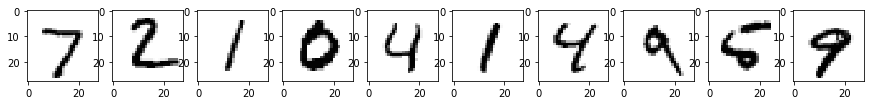

In [5]:
plt.figure(figsize=(15,5))
for i in list(range(10)):
    plt.subplot(1, 10, i+1)
    pixels = mnist.test.images[i]
    pixels = pixels.reshape((28, 28))
    plt.imshow(pixels, cmap='gray_r')
plt.show()

In [6]:
def glimpse(pixels,x,y,r):
    w,h = 28,28
    p = pixels.reshape((w,h))
    
    # x are columns, y are rows!  
    py_l, py_r = (max(0,r-y), max(0,(y+r)-h))
    px_l, px_r = (max(0,r-x), max(0,(x+r)-w))
    
    p_padded = np.lib.pad(p, ((py_l, py_r),(px_l, px_r)), 'constant', constant_values=0)
    g = p_padded[py_l+y-r:py_l+y+r+1,px_l+x-r:px_l+x+r+1]
    return g

In [7]:
import math
def glimpses(pixels, n=1):
    g = []
    k = int(math.sqrt(n-1))//2
    r = list(range(-k, k+1))
    if type(n)==list:
        r = n
    for i in r:
        for j in r:
            g.append(glimpse(pixels,14+7*j,14+7*i,5))
    return np.array(g)

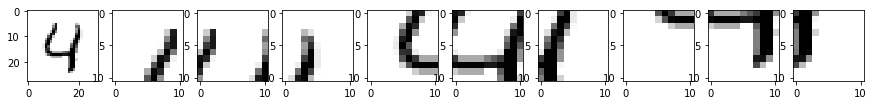

In [8]:
pixels = mnist.test.images[4]
plt.figure(figsize=(15,5))

# plot the full field
plt.subplot(1, 10, 1)
plt.imshow(glimpse(pixels,14,14,14), cmap='gray_r')

# plot 9 glimpses
i = 2
for g in glimpses(pixels,9):
    plt.subplot(1, 10, i)
    plt.imshow(g, cmap='gray_r')
    i += 1
plt.show()

In [144]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(32, input_length=9, input_dim=121))
model.add(Dense(10, activation='softmax'))

from keras.optimizers import Adam
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=["accuracy"])


In [145]:
from keras.utils.layer_utils import print_summary
print_summary(model.layers)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_21 (LSTM)                   (None, 32)            19712       lstm_input_9[0][0]               
____________________________________________________________________________________________________
dense_37 (Dense)                 (None, 10)            330         lstm_21[0][0]                    
Total params: 20,042
Trainable params: 20,042
Non-trainable params: 0
____________________________________________________________________________________________________


In [146]:
def sequence(x,n):
    return glimpses(x,n).reshape((n*121))

In [147]:
# prepare the train/test input as a tensor of shape 55000, 9, 121
train_sequences = np.apply_along_axis(sequence, 1, mnist.train.images,9).reshape(-1,9,121)
test_sequences  = np.apply_along_axis(sequence, 1, mnist.test.images,9).reshape(-1,9,121)

In [148]:
model.fit(train_sequences, mnist.train.labels,
          batch_size=250, nb_epoch=5, verbose=1, 
          validation_data=(test_sequences, mnist.test.labels))

Train on 55000 samples, validate on 10000 samples
Epoch 1/5
55000/55000 [==============================] - 7s - loss: 0.4257 - acc: 0.8685 - val_loss: 0.1548 - val_acc: 0.9547

In [149]:
from keras.layers import Reshape

model = Sequential()
model.add(Reshape((9*121,), input_shape=(9,121,)))
model.add(Dense(32))
model.add(Dense(10, activation='softmax'))

from keras.optimizers import Adam
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=["accuracy"])


In [150]:
from keras.utils.layer_utils import print_summary
print_summary(model.layers)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
reshape_66 (Reshape)             (None, 1089)          0           reshape_input_51[0][0]           
____________________________________________________________________________________________________
dense_38 (Dense)                 (None, 32)            34880       reshape_66[0][0]                 
____________________________________________________________________________________________________
dense_39 (Dense)                 (None, 10)            330         dense_38[0][0]                   
Total params: 35,210
Trainable params: 35,210
Non-trainable params: 0
____________________________________________________________________________________________________


In [151]:
model.fit(train_sequences, mnist.train.labels,
          batch_size=250, nb_epoch=5, verbose=1, 
          validation_data=(test_sequences, mnist.test.labels))

Train on 55000 samples, validate on 10000 samples
Epoch 1/5
55000/55000 [==============================] - 1s - loss: 0.4019 - acc: 0.8857 - val_loss: 0.3178 - val_acc: 0.9102

In [ ]:
# Multilayer LSTM

In [152]:
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_length=9, input_dim=121))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(10, activation='softmax'))

from keras.optimizers import Adam
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=["accuracy"])

In [153]:
model.fit(train_sequences, mnist.train.labels,
          batch_size=250, nb_epoch=5, verbose=1, 
          validation_data=(test_sequences, mnist.test.labels))

Train on 55000 samples, validate on 10000 samples
Epoch 1/5
55000/55000 [==============================] - 19s - loss: 0.4690 - acc: 0.8493 - val_loss: 0.1386 - val_acc: 0.9587

In [215]:
# Convolutional + Multilayer LSTM 
from keras.models import Model

from keras.layers import TimeDistributed
from keras.layers import Flatten, Reshape
from keras.layers import Convolution2D, MaxPooling2D, BatchNormalization

def conv_net():
    def f(_in):
        # go to 32 channels
        layer = Convolution2D(16, 3, 3, border_mode="same", activation="relu")(_in)
        layer = Convolution2D(16, 3, 3, border_mode="same", activation="relu")(_in)
        layer = MaxPooling2D((2, 2))(layer)
        layer = Flatten()(layer)
        _out  = Dense(64, activation='relu')(layer)
        return _out
    return f

#create the conv_model
x = Input(shape=(11, 11, 1))
conv_model = Model(x,conv_net()(x))  
            
# build the top model
model = Sequential()

#prep for convolution, keep the timestep as first dimension (after the implicit batch dim)
model.add(Reshape((9,11,11,1), input_shape=(9,121)))

# time distributed on the convolutional part
model.add(TimeDistributed(conv_model))

# temporal model (64 is de output dim of the conv_model)
model.add(LSTM(32, return_sequences=True, input_length=9, input_dim=64))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))

# last layer
model.add(Dense(10, activation='softmax'))

from keras.optimizers import Adam
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=["accuracy"])

In [216]:
from keras.utils.layer_utils import print_summary
print_summary(conv_model.layers)
print_summary(model.layers)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_41 (InputLayer)            (None, 11, 11, 1)     0                                            
____________________________________________________________________________________________________
convolution2d_98 (Convolution2D) (None, 11, 11, 16)    160         input_41[0][0]                   
____________________________________________________________________________________________________
maxpooling2d_45 (MaxPooling2D)   (None, 5, 5, 16)      0           convolution2d_98[0][0]           
____________________________________________________________________________________________________
flatten_54 (Flatten)             (None, 400)           0           maxpooling2d_45[0][0]            
___________________________________________________________________________________________

In [218]:
model.fit(train_sequences, mnist.train.labels,
          batch_size=250, nb_epoch=5, verbose=1, 
          validation_data=(test_sequences, mnist.test.labels))

Train on 55000 samples, validate on 10000 samples
Epoch 1/5
55000/55000 [==============================] - 30s - loss: 0.0433 - acc: 0.9874 - val_loss: 0.0655 - val_acc: 0.9804

KeyboardInterrupt: 